In [1]:
#conda activate torch-xla-nightly
#export XRT_TPU_CONFIG="tpu_worker;0;$10.0.101.2:8470"
#git init
#git remote add origin https://github.com/nosound2/RSNA-Hemorrhage
#git pull origin master
#git config remote.origin.push HEAD
#gcloud config set compute/zone europe-west4-a
#gcloud auth login
#gcloud config set project endless-empire-239015
#pip install kaggle
#mkdir .kaggle
#gsutil cp gs://recursion-double-strand/kaggle-keys/kaggle.json ~/.kaggle
#chmod 600 /home/zahar_chikishev/.kaggle/kaggle.json
#kaggle competitions download rsna-intracranial-hemorrhage-detection -f stage_1_train.csv
#sudo apt install unzip
#unzip stage_1_train.csv.zip
#kaggle kernels output xhlulu/rsna-generate-metadata-csvs -p .
#gsutil cp gs://rsna-hemorrhage/yuvals/* .

#export XRT_TPU_CONFIG="tpu_worker;0;10.0.101.2:8470"; conda activate torch-xla-nightly; jupyter notebook

# 35.204.242.164

In [2]:
VERSION = 51
CLOUD_SINGLE = False
MIXUP = False
DATA_SET = 2
NO_BLACK_LOSS = True

In [3]:
import sys

from pathlib import Path
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import time
from random import randint
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,log_loss,roc_auc_score
from scipy.stats import ks_2samp

import pdb

import scipy as sp
from tqdm import tqdm, tqdm_notebook

import os
import glob

import torch

CLOUD = not torch.cuda.is_available()

if not CLOUD:
    torch.cuda.current_device()

import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
import torch.utils as U

import torchvision
from torchvision import transforms as T
from torchvision import models as M

import matplotlib.pyplot as plt

if CLOUD:
    PATH = Path('/home/zahar_chikishev')
    PATH_WORK = Path('/home/zahar_chikishev/running')
else:
    PATH = Path('C:/StudioProjects/Hemorrhage')
    PATH_WORK = Path('C:/StudioProjects/Hemorrhage/running')

from collections import defaultdict, Counter
import random
import seaborn as sn

pd.set_option("display.max_columns", 100)

all_ich = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
class_weights = 6.0*np.array([2,1,1,1,1,1])/7.0

if CLOUD:
    import torch_xla
    import torch_xla.distributed.data_parallel as dp
    import torch_xla.utils as xu
    import torch_xla.core.xla_model as xm
    
    from typing import Collection

In [4]:
all_black = '006d4432e'

if CLOUD:
    device = xm.xla_device()
    #device = 'cpu'
    MAX_DEVICES = 1 if CLOUD_SINGLE else 8
    bs = 32
else:
    device = 'cuda'
    #device = 'cpu'
    MAX_DEVICES = 1
    bs = 16

if CLOUD and (not CLOUD_SINGLE):
    devices = xm.get_xla_supported_devices(max_devices=MAX_DEVICES)

In [5]:
SEED = 2351

def setSeeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

setSeeds(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
cols_le,cols_float,cols_bool = pickle.load(open(PATH_WORK/'covs','rb'))
meta_cols = cols_bool + cols_float

In [7]:
#meta_cols = ['ImagePositionPatient_1','pos_rel']

In [8]:
if DATA_SET == 1:
    if False:
        filename = PATH_WORK/'indexes_file.pkl'
        all_idx, train_ids, val_ids = pickle.load(open(filename,'rb'))

        train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        ids_df = pd.DataFrame(all_idx, columns = ['img_id'])
        ids_df = ids_df.join(train_md.set_index('img_id'), on = 'img_id')
        
        assert len(ids_df.SeriesInstanceUID.unique()) == 19530
        
        trn_data = ids_df.loc[ids_df.img_id.isin(all_idx[train_ids])].reset_index(drop=True)
        val_data = ids_df.loc[ids_df.img_id.isin(all_idx[val_ids])].reset_index(drop=True)

        assert len(trn_data.SeriesInstanceUID.unique()) + len(val_data.SeriesInstanceUID.unique()) \
            == len(train_md.SeriesInstanceUID.unique())

        assert len(trn_data.PatientID.unique()) + len(val_data.PatientID.unique()) \
            >= len(train_md.PatientID.unique())

        pickle.dump((trn_data,val_data), open(PATH_WORK/'train.post.processed.1','wb'))
    else:
        trn_data,val_data = pickle.load(open(PATH_WORK/'train.post.processed.1','rb'))

In [9]:
if DATA_SET == 1:
    if False:
        test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        filename = PATH_WORK/'test_indexes.pkl'
        test_ids = pickle.load(open(filename,'rb'))

        test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
        test_md = test_ids_df.join(test_md.set_index('img_id'), on = 'img_id')

        assert len(test_md.SeriesInstanceUID.unique()) == 2214

        pickle.dump(test_md, open(PATH_WORK/'test.post.processed.1','wb'))
    else:
        test_md = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))

In [10]:
if False:
    print(pd.concat([test_md[meta_cols].mean(0),
                     trn_data[meta_cols].mean(0),
                     val_data[meta_cols].mean(0)], axis=1))

# Pre-processing

In [11]:
if DATA_SET == 1:
    dataset_name = 'Densenet161'
    feat_sz = 2208
elif DATA_SET == 2:
    dataset_name = 'Densenet169'
    feat_sz = 208
elif DATA_SET == 3:
    dataset_name = 'Densenet201'
    feat_sz = 208
else: assert False

In [52]:
if (DATA_SET == 2) or (DATA_SET == 3):
    if False:
        train_dedup = pd.read_csv(PATH_WORK/'yuval'/'train_dedup.csv')
        pids, folding = pickle.load(open(PATH_WORK/'yuval'/'PID_splits.pkl','rb'))

        assert len(pids) == 17079
        assert len(np.unique(pids)) == 17079

        for fol in folding:
            assert len(fol[0]) + len(fol[1]) == 17079

        assert len(folding[0][1]) + len(folding[1][1]) + len(folding[2][1]) == 17079

        assert len(train_dedup.PID.unique()) == 17079

        train_dedup['fold'] = np.nan

        for fold in range(3):
            train_dedup.loc[train_dedup.PID.isin(pids[folding[fold][1]]),'fold'] = fold

        assert train_dedup.fold.isnull().sum() == 0

        train_md = pd.read_csv(PATH_WORK/'train_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        train_md['img_id'] = train_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])

        ids_df = train_dedup[['fold','PatientID']]
        ids_df.columns = ['fold','img_id']

        ids_df = ids_df.join(train_md.set_index('img_id'), on = 'img_id')

        pickle.dump(ids_df, open(PATH_WORK/'features/{}_v3/train/train.ids.df'.format(dataset_name),'wb'))

        #test_md = pickle.load(open(PATH_WORK/'test.post.processed.1','rb'))
        test_md = pd.read_csv(PATH_WORK/'test_md.csv').sort_values(['SeriesInstanceUID','pos_idx1'])
        test_md['img_id'] = test_md.SOPInstanceUID.str.split('_').apply(lambda x: x[1])
        
        filename = PATH_WORK/'test_indexes.pkl'
        test_ids = pickle.load(open(filename,'rb'))

        test_ids_df = pd.DataFrame(test_ids, columns = ['img_id'])
        test_md = test_ids_df.join(test_md.set_index('img_id'), on = 'img_id')
        
        assert len(test_md.SeriesInstanceUID.unique()) == 2214
        
        pickle.dump(test_md, open(PATH_WORK/'features/{}_v3/test/test.ids.df'.format(dataset_name),'wb'))

        for fold in range(3):
            filename = PATH_WORK/'yuval'/\
                'model_{}_3_version_classifier_splits_type_features_train_tta_split_{}.pkl'\
                .format(dataset_name, fold)
            feats = pickle.load(open(filename,'rb'))
            assert len(feats) == 4*len(ids_df)

            for i in range(4):
                feats_sub1 = feats[torch.BoolTensor(np.arange(len(feats))%4 == i)]
                feats_sub2 = feats_sub1[torch.BoolTensor(train_dedup.fold != fold)]
                pickle.dump(feats_sub2, open(PATH_WORK/'features/{}_v3/train/train.f{}.a{}'
                                             .format(dataset_name,fold,i),'wb'))

                feats_sub2 = feats_sub1[torch.BoolTensor(train_dedup.fold == fold)]
                pickle.dump(feats_sub2, open(PATH_WORK/'features/{}_v3/train/valid.f{}.a{}'
                                             .format(dataset_name,fold,i),'wb'))

                if i==0:
                    black_feats = feats_sub1[torch.BoolTensor(ids_df.img_id == all_black)].squeeze()
                    pickle.dump(black_feats, open(PATH_WORK/'features/{}_v3/train/black.f{}'
                                                  .format(dataset_name,fold),'wb'))

        for fold in range(3):
            filename = PATH_WORK/'yuval'/\
                'model_{}_3_version_classifier_splits_type_features_test_split_{}.pkl'\
                .format(dataset_name,fold)
            feats = pickle.load(open(filename,'rb'))

            for i in range(8):
                feats_sub = feats[torch.BoolTensor(np.arange(len(feats))%8 == i)]
                pickle.dump(feats_sub, open(PATH_WORK/'features/{}_v3/test/test.f{}.a{}'
                                            .format(dataset_name,fold,i),'wb'))
                assert len(feats_sub) == len(test_md)
    else:
        ids_df = pickle.load(open(PATH_WORK/'features/{}_v3/train/train.ids.df'.format(dataset_name),'rb'))
        test_md = pickle.load(open(PATH_WORK/'features/{}_v3/test/test.ids.df'.format(dataset_name),'rb'))

In [13]:
if DATA_SET == 1:
    if False:
        filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_train_split_2.pkl'
        feats = pickle.load(open(filename,'rb'))

        for series_id in tqdm(ids_df.SeriesInstanceUID.unique()):
            mask = torch.BoolTensor(ids_df.SeriesInstanceUID.values == series_id)
            feats_id = feats[mask]
            pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/train/{}'.format(series_id),'wb'))


        filename = PATH_WORK/'model_Densenet161_3_vehrsion_basic_classifier_type_features_test_split_2.pkl'
        feats = pickle.load(open(filename,'rb'))

        for series_id in tqdm(test_md.SeriesInstanceUID.unique()):
            mask = torch.BoolTensor(test_md.SeriesInstanceUID.values == series_id)
            feats_id = feats[mask]
            pickle.dump(feats_id, open(PATH_WORK/'features/densenet161_v3/test/{}'.format(series_id),'wb'))

# Dataset

In [14]:
#path = PATH_WORK/'features/densenet161_v3/train/ID_000a935543'
#feats1 = pickle.load(open(path,'rb'))

In [15]:
if DATA_SET == 1:
    path = PATH_WORK/'features/densenet161_v3/train/ID_992b567eb6'
    black_feats = pickle.load(open(path,'rb'))[41]

In [16]:
class RSNA_DataSet(D.Dataset):
    def __init__(self, metadata, mode='train', bs=None, dataset=DATA_SET, fold=0):
        
        super(RSNA_DataSet, self).__init__()
        
        if dataset == 1:
            md = metadata.copy()
            md = md.reset_index(drop=True)
        else:
            if mode == 'train':
                md = metadata.loc[metadata.fold != fold].copy().reset_index(drop=True)
            elif mode == 'valid':
                md = metadata.loc[metadata.fold == fold].copy().reset_index(drop=True)
            else:
                md = metadata.copy().reset_index(drop=True)
        
        series = np.sort(md.SeriesInstanceUID.unique())
        md = md.set_index('SeriesInstanceUID', drop=True)
        
        samples_add = 0
        if (mode != 'train') and not DATA_SMALL:
            batch_num = -((-len(series))//(bs*MAX_DEVICES))
            samples_add = batch_num*bs*MAX_DEVICES - len(series)
            print('adding dummy serieses', samples_add)
        
        #self.records = df.to_records(index=False)
        self.mode = mode
        self.real = np.concatenate([np.repeat(True,len(series)),np.repeat(False,samples_add)])
        self.series = np.concatenate([series, random.sample(list(series),samples_add)])
        self.metadata = md
        self.dataset = dataset
        self.fold = fold
        
        print('DataSet', dataset, mode, 'size', len(self.series), 'fold', fold)
        
        if self.dataset >= 2:
            path = PATH_WORK/'features/{}_v3/train/black.f{}'.format(dataset_name, fold)
            self.black_feats = pickle.load(open(path,'rb')).squeeze()
            
            if mode == 'valid':
                self.setFeats(0)
            
        elif self.dataset == 1:
            self.black_feats = black_feats
    
    def setFeats(self, anum):
        def getAPath(an):
            return PATH_WORK/'features/{}_v3/{}/{}.f{}.a{}'.format(dataset_name,folder,self.mode,self.fold,an)
        
        if self.dataset == 1: return
        print('setFeats, augmentation', anum)
        self.anum = anum
        folder = 'test' if self.mode == 'test' else 'train'
        sz = len(self.metadata)
        if anum == -1:
            max_a = 8 if self.mode == 'test' else 4
            feats2 = torch.stack([pickle.load(open(getAPath(an),'rb')) for an in range(max_a)])
            feats = feats2[torch.randint(max_a,(sz,)), torch.arange(sz)].squeeze()
        else:
            feats = pickle.load(open(getAPath(anum),'rb'))
        
        self.feats = feats
        assert len(feats) == sz
    
    def __getitem__(self, index):
        
        series_id = self.series[index]
        #df = self.metadata.loc[self.metadata.SeriesInstanceUID == series_id].reset_index(drop=True)
        df = self.metadata.loc[series_id].reset_index(drop=True)
        
        if self.dataset == 1:
            folder = 'test' if self.mode == 'test' else 'train'
            path = PATH_WORK/'features/densenet161_v3/{}/{}'.format(folder,series_id)
            feats = pickle.load(open(path,'rb'))
            
            if feats.shape[0] > len(df.img_id.unique()):
                mask_dup = ~df.img_id.duplicated().values
                df = df.loc[mask_dup]
                feats = feats[torch.BoolTensor(mask_dup)]
            
            assert feats.shape[0] == len(df)
        elif self.dataset >= 2:
            feats = self.feats[torch.BoolTensor(self.metadata.index.values == series_id)]
        else: assert False
        
        order = np.argsort(df.pos_idx1.values)
        df = df.sort_values(['pos_idx1'])
        feats = feats[torch.LongTensor(order)]
        
        non_black = torch.ones(len(feats))
        feats = torch.cat([feats, torch.Tensor(df[meta_cols].values)], dim=1)
        feats_le = torch.LongTensor(df[cols_le].values)
        
        target = torch.Tensor(df[all_ich].values)
        
        PAD = 4+9+1
        #PAD = 3
        
        offset = np.random.randint(0, 61 - feats.shape[0])
        #offset = 0
        top_pad = PAD + offset
        if top_pad > 0:
            dummy_row = torch.cat([self.black_feats, torch.Tensor(df.head(1)[meta_cols].values).squeeze()])
            feats = torch.cat([dummy_row.repeat(top_pad,1), feats], dim=0)
            feats_le = torch.cat([torch.LongTensor(df.head(1)[cols_le].values).squeeze().repeat(top_pad,1), feats_le])
            if offset > 0:
                non_black = torch.cat([torch.zeros(offset), non_black])
                target = torch.cat([torch.zeros((offset, len(all_ich))), target], dim=0)
        bot_pad = 60 - len(df) - offset + PAD
        if bot_pad > 0:
            dummy_row = torch.cat([self.black_feats, torch.Tensor(df.tail(1)[meta_cols].values).squeeze()])
            feats = torch.cat([feats, dummy_row.repeat(bot_pad,1)], dim=0)
            feats_le = torch.cat([feats_le, torch.LongTensor(df.head(1)[cols_le].values).squeeze().repeat(bot_pad,1)])
            if (60 - len(df) - offset) > 0:
                non_black = torch.cat([non_black, torch.zeros(60 - len(df) - offset)])
                target = torch.cat([target, torch.zeros((60 - len(df) - offset, len(all_ich)))], dim=0)
        
        assert feats_le.shape[0] == (60 + 2*PAD)
        assert feats.shape[0] == (60 + 2*PAD)
        assert target.shape[0] == 60
        
        #feats = feats.transpose(1,0)
        
        idx = index
        if not self.real[index]: idx = -1
        
        if self.mode == 'train':
            return feats, feats_le, target, non_black
        else:
            return feats, feats_le, target, idx, offset
    
    def __len__(self):
        return len(self.series) if not DATA_SMALL else int(0.01*len(self.series))

In [17]:
def getCurrentBatch(fold=0):
    sel_batch = None
    for filename in os.listdir(PATH_WORK/'models'):
        splits = filename.split('.')
        if int(splits[2][1]) != fold: continue
        if int(splits[3][1:]) != VERSION: continue
        if sel_batch is None:
            sel_batch = int(splits[1][1:])
        else:
            sel_batch = max(sel_batch, int(splits[1][1:]))
    return sel_batch

def modelFileName(fold=0, batch = 1, return_last = False, return_next = False):
    sel_batch = batch
    if return_last or return_next:
        sel_batch = getCurrentBatch(fold)
        if return_last and sel_batch is None:
            return None
        if return_next:
            if sel_batch is None: sel_batch = 1
            else: sel_batch += 1
    
    return 'model.b{}.f{}.v{}'.format(sel_batch, fold, VERSION)

# Model

In [18]:
class BCEWithLogitsLoss(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.weight = weight
    
    def forward(self, input, target, batch_weights = None):
        loss = (torch.log(1+torch.exp(input)) - target*input)*self.weight
        if batch_weights is not None:
            loss = batch_weights*loss
        return loss.mean()

In [19]:
def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

In [20]:
act_fun = nn.ReLU(inplace=True)

def conv_layer(ni, nf, ks=3, act=True):
    bn = nn.BatchNorm1d(nf)
    layers = [nn.Conv1d(ni, nf, ks), bn]
    if act: layers.append(act_fun)
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, ni, nh):
        super().__init__()
        layers  = [conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, act=False)]
        self.convs = nn.Sequential(*layers)

    def forward(self, x): return act_fun(self.convs(x) + x[:,:,1:-1])

In [21]:
class ResNetModel(nn.Module):
    def __init__(self, n_cont:int, feat_sz=2208):
        super().__init__()
        self.feat_sz = feat_sz
        self.bn_cont = nn.BatchNorm1d(n_cont)
        self.n_cont = n_cont
        
        self.conv2D = nn.Conv2d(1,64,(feat_sz + n_cont,1))
        
        self.res1 = ResBlock(64,64)
        self.res2 = ResBlock(64,64)
        self.res3 = ResBlock(64,64)
        
        self.conv1D = nn.Conv1d(64,6,1)
    
    def forward(self, x) -> torch.Tensor:
        x = torch.cat([x[:,:self.feat_sz],self.bn_cont(x[:,self.feat_sz:])], dim=1)
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        
        x = self.conv2D(x).squeeze()
        x = act_fun(x)
        
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        
        x = self.conv1D(x)
        x = x.transpose(1,2)
        return x

In [22]:
class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, n_cont:int, feat_sz=2208, fc_drop_p=0.3):
        super().__init__()
        #self.bn_cont = nn.BatchNorm1d(feat_sz + n_cont)
        self.le_sz = 9
        le_in_sizes = np.array([5,5,7,4,4,11,4,6,3])
        le_out_sizes = np.array([3,3,4,2,2,6,2,4,2])
        le_out_sz = le_out_sizes.sum()
        self.embeddings = nn.ModuleList([nn.Embedding(le_in_sizes[i], le_out_sizes[i]) for i in range(self.le_sz)])
        
        self.feat_sz = feat_sz
        self.bn_cont = nn.BatchNorm1d(n_cont)
        self.n_cont = n_cont
        self.fc_drop = nn.Dropout(p=fc_drop_p)
        self.relu = nn.ReLU(inplace=True)
        self.conv2D_1 = nn.Conv2d(1,64,(feat_sz + n_cont + le_out_sz,1))
        self.conv2D_2 = nn.Conv2d(1,64,(feat_sz + n_cont + le_out_sz,5))
        self.bn_cont1 = nn.BatchNorm1d(128)
        self.conv1D_1 = nn.Conv1d(128,64,3)
        self.conv1D_3 = nn.Conv1d(128,64,5,dilation=5)
        self.conv1D_2 = nn.Conv1d(128,6,3)
        self.bn_cont2 = nn.BatchNorm1d(128)
        self.bn_cont3 = nn.BatchNorm1d(6)

        self.conv1D_4 = nn.Conv1d(128,128,3)
        self.bn_cont4 = nn.BatchNorm1d(128)

    def forward(self, x, x_le) -> torch.Tensor:
        x_le = [e(x_le[:,:,i]) for i,e in enumerate(self.embeddings)]
        x_le = torch.cat(x_le, 2)
        x = torch.cat([x, x_le], 2)
        x = x.transpose(1,2)
        
        #x = torch.cat([x[:,:self.feat_sz],self.bn_cont(x[:,self.feat_sz:])], dim=1) # bs,2208,60
        x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2]) # bs,1,2208,60
        x = self.fc_drop(x)
        x = torch.cat([self.conv2D_1(x[:,:,:,2:(-2)]).squeeze(), 
                       self.conv2D_2(x).squeeze()], dim=1) # bs,64,60
        x = self.relu(x)
        x = self.bn_cont1(x)
        x = self.fc_drop(x)
        #x = self.conv1D_1(x)
        
        x = torch.cat([self.conv1D_1(x[:,:,9:(-9)]), 
                       self.conv1D_3(x)], dim=1) # bs,64,60
        x = self.relu(x)
        x = self.bn_cont2(x)
        x = self.fc_drop(x)
        
        x = self.conv1D_4(x)
        x = self.relu(x)
        x = self.bn_cont4(x)
        
        x = self.conv1D_2(x)
        x = x.transpose(1,2) # bs,60,6
        return x

# Training

In [23]:
def train_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 4
        generator = loader
        device_num = int(str(device)[-1])
        dataset = loader._loader._loader.dataset
    else:
        tlen = len(loader)
        OUT_LOSS = 10
        OUT_TIME = 1
        generator = enumerate(loader)
        device_num = 1
        dataset = loader.dataset
    
    #print('Start training {}'.format(device), 'batches', tlen)
    
    criterion = BCEWithLogitsLoss(weight = torch.Tensor(class_weights).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(0.9, 0.99))
    
    model.train()
    
    if CLOUD:
        tracker = xm.RateTracker()

    tloss = 0
    tloss_count = 0
    
    st = time.time()
    mixup_collected = False
    for i, (x, x_le, y, non_black) in generator:
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            x_le = x_le.to(device)
            y = y.to(device)
            non_black = non_black.to(device)
        
        if MIXUP:
            if mixup_collected:
                lambd = np.random.beta(0.4, 0.4, y.size(0))
                lambd = torch.Tensor(lambd).to(device)[:,None,None]
                #shuffle = torch.randperm(y.size(0)).to(device)
                x = lambd * x + (1-lambd) * x_mix #x[shuffle]
                mixup_collected = False
            else:
                x_mix = x
                y_mix = y
                mixup_collected = True
                continue
        
        optimizer.zero_grad()
        output = model(x, x_le)
        
        if MIXUP:
            if NO_BLACK_LOSS:
                loss = criterion(output, y, lambd*non_black[:,:,None]) \
                     + criterion(output, y_mix, (1-lambd)*non_black[:,:,None])
            else:
                loss = criterion(output, y, lambd) + criterion(output, y_mix, 1-lambd)
            del x_mix, y_mix
        else:
            if NO_BLACK_LOSS:
                loss = criterion(output, y, non_black[:,:,None])
            else:
                loss = criterion(output, y)
        
        loss.backward()
        
        tloss += len(y)*loss.cpu().detach().item()
        tloss_count += len(y)
        
        if CLOUD or CLOUD_SINGLE:
            xm.optimizer_step(optimizer)
            if CLOUD_SINGLE:
                xm.mark_step()
        else:
            optimizer.step()
        
        if CLOUD:
            tracker.add(len(y))
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            #print(torch_xla._XLAC._xla_metrics_report())
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del loss, output, y, x, x_le
    
    return tloss, tloss_count

In [24]:
@torch.no_grad()
def val_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 4
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start validating {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, x_le, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            x_le = x_le.to(device)
        
        output = torch.sigmoid(model(x, x_le))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('Batch {} device: {} time passed: {:.3f} time per batch: {:.3f}'
                  .format(i+1, device, st_passed, st_passed/(i+1)))
        
        del output, y, x, x_le, idx, offset
    
    results = np.concatenate(results)
    indices = np.concatenate(indices)
    offsets = np.concatenate(offsets)
    
    return results, indices, offsets

In [53]:
@torch.no_grad()
def test_loop_fn(model, loader, device, context = None):
    
    if CLOUD and (not CLOUD_SINGLE):
        tlen = len(loader._loader._loader)
        OUT_LOSS = 1000
        OUT_TIME = 100
        generator = loader
        device_num = int(str(device)[-1])
    else:
        tlen = len(loader)
        OUT_LOSS = 1000
        OUT_TIME = 10
        generator = enumerate(loader)
        device_num = 1
    
    #print('Start testing {}'.format(device), 'batches', tlen)
    
    st = time.time()
    model.eval()
    
    results = []
    indices = []
    offsets = []
    
    for i, (x, x_le, y, idx, offset) in generator:
        
        if (not CLOUD) or CLOUD_SINGLE:
            x = x.to(device)
            x_le = x_le.to(device)
        
        output = torch.sigmoid(model(x, x_le))
        
        mask = (idx >= 0)
        results.append(output[mask].cpu().detach().numpy())
        indices.append(idx[mask].cpu().detach().numpy())
        offsets.append(offset[mask].cpu().detach().numpy())
        
        st_passed = time.time() - st
        if (i+1)%OUT_TIME == 0 and device_num == 1:
            print('B{} -> time passed: {:.3f} time per batch: {:.3f}'.format(i+1, st_passed, st_passed/(i+1)))
        
        del output, x, y, idx, offset
    
    return np.concatenate(results), np.concatenate(indices), np.concatenate(offsets)

In [39]:
def train_one(weight=None, load_model=True, epochs=1, bs=100, fold=0):
    
    st0 = time.time()
    
    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch, 'starting now:', epochs)
    
    setSeeds(SEED + cur_epoch)
    
    if DATA_SET == 1:
        trn_ds = RSNA_DataSet(trn_data, mode='train', bs=bs, fold=fold)
        val_ds = RSNA_DataSet(val_data, mode='valid', bs=bs, fold=fold)
    elif DATA_SET >= 2:
        trn_ds = RSNA_DataSet(ids_df, mode='train', bs=bs, fold=fold)
        val_ds = RSNA_DataSet(ids_df, mode='valid', bs=bs, fold=fold)
    else: assert False
    
    loader = D.DataLoader(trn_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                          shuffle=True, drop_last=True)
    loader_val = D.DataLoader(val_ds, num_workers=16 if (CLOUD and not CLOUD_SINGLE) else 0, batch_size=bs, 
                              shuffle=True)
    print('dataset train:', len(trn_ds), 'valid:', len(val_ds), 'loader train:', len(loader), 'valid:', len(loader_val))
    
    model = TabularModel(n_cont = len(meta_cols), feat_sz=feat_sz, fc_drop_p=0)
    #model = ResNetModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    else:
        print('starting from scratch')
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)
        
    loc_data = val_ds.metadata.copy()

    if DATA_SMALL:
        #val_sz = int(0.01*len(loc_data.index.unique()))
        val_sz = len(val_ds)
        val_series = val_ds.series[:val_sz]
        loc_data = loc_data.loc[loc_data.index.isin(val_series)]
    
    series_counts = loc_data.index.value_counts()
    
    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx1'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    for i in range(cur_epoch+1, cur_epoch+epochs+1):
        st = time.time()
        
        #trn_ds.setFeats((i-1) % 4)
        trn_ds.setFeats(-1)
        
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(train_loop_fn, loader)
            tloss, tloss_count = np.stack(results).sum(0)
            state_dict = model_parallel._models[0].state_dict()
        else:
            tloss, tloss_count = train_loop_fn(model, loader, device)
            state_dict = model.state_dict()
        
        state_dict = {k:v.to('cpu') for k,v in state_dict.items()}
        tr_ll = tloss / tloss_count
        
        train_time = time.time()-st
        
        model_file_name = modelFileName(return_next=True, fold=fold)
        if not DATA_SMALL:
            torch.save(state_dict, PATH_WORK/'models'/model_file_name)
        
        st = time.time()
        if CLOUD and (not CLOUD_SINGLE):
            results = model_parallel(val_loop_fn, loader_val)
            predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
            indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
            offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
        else:
            predictions, indices, offsets = val_loop_fn(model, loader_val, device)
        
        predictions = predictions[np.argsort(indices)]
        offsets = offsets[np.argsort(indices)]
        assert len(predictions) == len(loc_data.index.unique())
        assert len(predictions) == len(offsets)
        assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
        
        #val_results = np.zeros((len(loc_data),6))
        val_results = []
        for k, series in enumerate(np.sort(loc_data.index.unique())):
            cnt = series_counts[series]
            #mask = loc_data.SeriesInstanceUID == series
            assert (offsets[k] + cnt) <= 60
            #val_results[mask] = predictions[k,offsets[k]:(offsets[k] + cnt)]
            val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])
        
        val_results = np.concatenate(val_results)
        assert np.isnan(val_results).sum() == 0
        val_results = val_results[loc_data.my_order]
        assert np.isnan(val_results).sum() == 0
        assert len(val_results) == len(loc_data)
        
        lls = [log_loss(loc_data[all_ich[k]].values, val_results[:,k]+1e-15, eps=1e-8, labels=[0,1]) for k in range(6)]
        ll = (class_weights * np.array(lls)).mean()
        cor = np.corrcoef(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))[0,1]
        auc = roc_auc_score(loc_data.loc[:,all_ich].values.reshape(-1), val_results.reshape(-1))

        print('ver {}, epoch {}, fold {}, train ll: {:.4f}, val ll: {:.4f}, cor: {:.4f}, auc: {:.4f}, lr: {}'
              .format(VERSION, i, fold, tr_ll, ll, cor, auc, learning_rate))
        valid_time = time.time()-st

        epoch_stats = pd.DataFrame([[i, 0, tr_ll, ll, cor, lls[0], lls[1], lls[2], lls[3], lls[4], lls[5],
                                     len(trn_ds), len(val_ds), bs, train_time, valid_time,
                                     learning_rate, weight_decay]], 
                                   columns = 
                                    ['epoch','fold','train_loss','val_loss','cor',
                                     'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural',
                                     'train_sz','val_sz','bs','train_time','valid_time','lr','wd'
                                     ])

        stats_filename = PATH_WORK/'stats.f{}.v{}'.format(fold,VERSION)
        if stats_filename.is_file():
            epoch_stats = pd.concat([pd.read_csv(stats_filename), epoch_stats], sort=False)
        #if not DATA_SMALL:
        epoch_stats.to_csv(stats_filename, index=False)
    
    print('total running time', time.time() - st0)
    
    return model, predictions

In [27]:
#Batch 22 device: xla:1 time passed: 277.972 time per batch: 12.635 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 209.280 time per batch: 9.513  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 213.209 time per batch: 9.691  - 16 cores / 32 workers
#Batch 22 device: xla:1 time passed: 275.780 time per batch: 12.535 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 208.826 time per batch: 9.492  - 16 cores / 16 workers
#Batch 22 device: xla:1 time passed: 245.750 time per batch: 11.170 - 16 cores / 12 workers
#Batch 22 device: xla:1 time passed: 374.876 time per batch: 17.040 - 16 cores / 8 workers
#Batch 22 device: xla:1 time passed: 400.221 time per batch: 18.192 - 8 cores / 8 workers

# Running

In [28]:
# 7x0.00002 more
# ver 51, epoch 28, fold 0, train ll: 0.0293, val ll: 0.0649, cor: 0.8417, auc: 0.9868, lr: 2e-05
# ver 51, epoch 32, fold 1, train ll: 0.0298, val ll: 0.0646, cor: 0.8379, auc: 0.9868, lr: 2e-05
# ver 51, epoch 28, fold 2, train ll: 0.0297, val ll: 0.0621, cor: 0.8411, auc: 0.9882, lr: 2e-05


# 7x0.002, 7x0.001, 7x0.0002
# new metadata
# ver 51, epoch 21, fold 0, train ll: 0.0299, val ll: 0.0651, cor: 0.8411, auc: 0.9869, lr: 0.0002
# ver 51, epoch 21, fold 1, train ll: 0.0302, val ll: 0.0647, cor: 0.8374, auc: 0.9874, lr: 0.0002
# ver 51, epoch 21, fold 2, train ll: 0.0302, val ll: 0.0625, cor: 0.8400, auc: 0.9881, lr: 0.0002

# same for all meta
# ver 50, epoch 27, fold 0, train ll: 0.0293, val ll: nan, cor: 0.8411, auc: 0.9855, lr: 5e-06

# 2x5e-06
# ver 49, epoch 27, fold 0, train ll: 0.0293, val ll: 0.0647, cor: 0.8417, auc: 0.9870, lr: 5e-06
# 2x0.00002, 2x0.00001
# ver 49, epoch 25, fold 0, train ll: 0.0295, val ll: 0.0648, cor: 0.8416, auc: 0.9871, lr: 1e-05
# 7x0.002, 7x0.001, 7x0.0002
# reduced to 2 meta cols
# ver 49, epoch 21, fold 0, train ll: 0.0300, val ll: 0.0656, cor: 0.8404, auc: 0.9858, lr: 0.0002

# 3x0.002, 3x0.001, 3x0.0002
# back to orig
# ver 48, epoch 9,  fold 0, train ll: 0.0300, val ll: 0.0677, cor: 0.8405, auc: 0.9839, lr: 0.0002
# ver 48, epoch 14, fold 0, train ll: 0.0297, val ll: 0.0688, cor: 0.8391, auc: 0.9837, lr: 0.0002

# resnet
# 3x0.002, 3x0.001, 3x0.0002
# ver 47, epoch 9, fold 0, train ll: 0.0299, val ll: 0.0677, cor: 0.8359, auc: 0.9857, lr: 0.0002

# relu and bn switched places
# ver 44, epoch 21, fold 0, train ll: 0.0326, val ll: 0.0667, cor: 0.8361, auc: 0.9867, lr: 0.0002
# all doubled size
# ver 43, epoch 21, fold 0, train ll: 0.0313, val ll: 0.0656, cor: 0.8403, auc: 0.9858, lr: 0.0002
# +layer
# ver 42, epoch 21, fold 0, train ll: 0.0315, val ll: 0.0654, cor: 0.8403, auc: 0.9867, lr: 0.0002

# 7x0.02, 7x0.002, 7x0.0002
# ver 41, epoch 21, fold 2, train ll: 0.0321, val ll: 0.0630, cor: 0.8400, auc: 0.9878, lr: 0.0002
# ver 41, epoch 21, fold 1, train ll: 0.0317, val ll: 0.0652, cor: 0.8370, auc: 0.9863, lr: 0.0002
# ver 41, epoch 21, fold 0, train ll: 0.0310, val ll: 0.0654, cor: 0.8407, auc: 0.9867, lr: 0.0002

# 7x0.02, 7x0.002, 3x0.0002
# mixing aug
# ver 41, epoch 17, fold 0, train ll: 0.0308, val ll: 0.0657, cor: 0.8406, auc: 0.9862, lr: 0.0002
# no bn for feats
# ver 40, epoch 14, fold 0, train ll: 0.0315, val ll: 0.0663, cor: 0.8400, auc: 0.9859, lr: 0.0002

# mixup
# ver 39, epoch 21, fold 1, train ll: 0.0496, val ll: 0.0688, cor: 0.8318, auc: 0.9859, lr: 0.0002

# no dropout
# ver 39, epoch 14, fold 1, train ll: 0.0335, val ll: 0.0663, cor: 0.8335, auc: 0.9852, lr: 0.0002
# ver 39, epoch 17, fold 0, train ll: 0.0322, val ll: 0.0680, cor: 0.8369, auc: 0.9843, lr: 0.0002
# bs=32, no black
# ver 39, epoch 14, fold 0, train ll: 0.0354, val ll: 0.0689, cor: 0.8351, auc: 0.9830, lr: 0.0002

# bs=16
# ver 38, epoch 14, fold 0, train ll: 0.0365, val ll: 0.0694, cor: 0.8330, lr: 0.0002
# ver 38, epoch 17, fold 0, train ll: 0.0362, val ll: 0.0684, cor: 0.8346, lr: 0.0001

# back to 64, dropped dilated
# ver 37, epoch 14, fold 2, train ll: 0.0367, val ll: 0.0641, cor: 0.8360, lr: 0.0002
# ver 37, epoch 14, fold 1, train ll: 0.0374, val ll: 0.0665, cor: 0.8324, lr: 0.0002
# ver 37, epoch 14, fold 0, train ll: 0.0360, val ll: 0.0676, cor: 0.8346, lr: 0.0002

# 3x0.0001
# ver 36, epoch 17, fold 2, train ll: 0.0364, val ll: 0.0646, cor: 0.8367
# ver 36, epoch 16, fold 1, train ll: 0.0375, val ll: 0.0663, cor: 0.8326
# ver 36, epoch 17, fold 0, train ll: 0.0358, val ll: 0.0677, cor: 0.8357

# 7x0.02, 4x0.002, 3x0.0002
# bs = 32
# ver 36, epoch 14, fold 2, train ll: 0.0366, val ll: 0.0647, cor: 0.8362
# ver 36, epoch 13, fold 1, train ll: 0.0379, val ll: 0.0663, cor: 0.8327
# ver 36, epoch 14, fold 0, train ll: 0.0359, val ll: 0.0674, cor: 0.8354

# 10x0.02, 6x0.002, 3x0.0002
# bs = 64
# ver 34, epoch 19, train ll: 0.0363, val ll: 0.0675, cor: 0.8347

#--- dataset 2

# 13x0.02, 6x0.002, 3x0.0002
# bs = 64
# ver 32, epoch 22, train ll: 0.0375, val ll: 0.0582, cor: 0.8480

#--- dataset 1

# 10x0.02, 8x0.002, 3x0.0002
# with augmentations
# ver 31, epoch 21, train ll: 0.0866, val ll: 0.1533, cor: 0.5319

# 10x0.02, 6x0.002, 3x0.0002
# 32 to 64 for conv2D reduce before, w dilated
# ver 26, epoch 19, train ll: 0.0867, val ll: 0.1531, cor: 0.5305

#--- dataset 2

# 10x0.02, 3x0.002, 6x0.0002 (+10x0.0002)
# back to orig best
# epoch 19, train ll: 0.0389, val ll: 0.0602, cor: 0.8424
# epoch 29, train ll: 0.0378, val ll: 0.0593, cor: 0.8448

# 3x0.05, 5x0.02, 3x0.002, 6x0.0002
# reduced all sizes
# epoch 17, train ll: 0.0407, val ll: 0.0620, cor: 0.8371

# 3x0.05, 5x0.02, 3x0.002, 6x0.0002
# 32 to 64 for conv2D reduce before, w dilated
# epoch 17, train ll: 0.0379, val ll: 0.0589, cor: 0.8460

# 3x0.1, 5x0.02, 3x0.002, 6x0.0002
# dilated, 3xTTA
# epoch 17, train ll: 0.0364, val ll: 0.0582, cor: 0.8454, LB 0.066

# train ll: 0.0354, val ll: 0.0577, cor: 0.8462, LB 0.065

In [29]:
# one-cycle
# copy latest model to GS code
# improve black image meta data
# freeze bias approach?
# pseudo-labelling?
# normalize metadata outliers
# try GCP fast guide connecting
# 32 TTA
# no auc

# Yuval: zoom in, squish, perspective wraping

In [30]:
DATA_SMALL = False
weight_decay = 1e-3
f = 0
learning_rate = 0.002
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.001
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.0002
model, predictions = train_one(epochs=7, bs=bs, fold=f)

completed epochs: 0 starting now: 7
DataSet 2 train size 13042 fold 0
adding dummy serieses 168
DataSet 2 valid size 6656 fold 0
setFeats, augmentation 0
dataset train: 13042 valid: 6656 loader train: 407 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 14.358 time per batch: 3.590
Batch 8 device: xla:1 time passed: 15.137 time per batch: 1.892
Batch 12 device: xla:1 time passed: 15.809 time per batch: 1.317
Batch 16 device: xla:1 time passed: 16.351 time per batch: 1.022
Batch 20 device: xla:1 time passed: 17.306 time per batch: 0.865
Batch 24 device: xla:1 time passed: 20.434 time per batch: 0.851
Batch 28 device: xla:1 time passed: 23.605 time per batch: 0.843
Batch 32 device: xla:1 time passed: 26.850 time per batch: 0.839
Batch 36 device: xla:1 time passed: 30.046 time per batch: 0.835
Batch 40 device: xla:1 time passed: 33.244 time per batch: 0.831
Batch 44 device: xla:1 time passed: 36.424 time per batch: 0.828
Batch 48 device: xla:1 

Batch 20 device: xla:1 time passed: 17.444 time per batch: 0.872
Batch 24 device: xla:1 time passed: 20.611 time per batch: 0.859
Batch 28 device: xla:1 time passed: 23.830 time per batch: 0.851
Batch 32 device: xla:1 time passed: 27.116 time per batch: 0.847
Batch 36 device: xla:1 time passed: 30.312 time per batch: 0.842
Batch 40 device: xla:1 time passed: 33.557 time per batch: 0.839
Batch 44 device: xla:1 time passed: 36.794 time per batch: 0.836
Batch 48 device: xla:1 time passed: 39.925 time per batch: 0.832
Batch 4 device: xla:1 time passed: 3.273 time per batch: 0.818
Batch 8 device: xla:1 time passed: 4.860 time per batch: 0.607
Batch 12 device: xla:1 time passed: 6.799 time per batch: 0.567
Batch 16 device: xla:1 time passed: 8.673 time per batch: 0.542
Batch 20 device: xla:1 time passed: 10.778 time per batch: 0.539
Batch 24 device: xla:1 time passed: 12.603 time per batch: 0.525
ver 51, epoch 7, fold 0, train ll: 0.0335, val ll: 0.0684, cor: 0.8361, auc: 0.9872, lr: 0.002
t

Batch 36 device: xla:1 time passed: 30.271 time per batch: 0.841
Batch 40 device: xla:1 time passed: 33.508 time per batch: 0.838
Batch 44 device: xla:1 time passed: 36.741 time per batch: 0.835
Batch 48 device: xla:1 time passed: 39.970 time per batch: 0.833
Batch 4 device: xla:1 time passed: 3.450 time per batch: 0.862
Batch 8 device: xla:1 time passed: 4.880 time per batch: 0.610
Batch 12 device: xla:1 time passed: 6.801 time per batch: 0.567
Batch 16 device: xla:1 time passed: 8.758 time per batch: 0.547
Batch 20 device: xla:1 time passed: 10.760 time per batch: 0.538
Batch 24 device: xla:1 time passed: 12.631 time per batch: 0.526
ver 51, epoch 13, fold 0, train ll: 0.0323, val ll: 0.0678, cor: 0.8374, auc: 0.9849, lr: 0.001
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.817 time per batch: 1.204
Batch 8 device: xla:1 time passed: 7.668 time per batch: 0.958
Batch 12 device: xla:1 time passed: 10.840 time per batch: 0.903
Batch 16 device: xla:1 time passed: 14.079 

Batch 4 device: xla:1 time passed: 3.604 time per batch: 0.901
Batch 8 device: xla:1 time passed: 5.305 time per batch: 0.663
Batch 12 device: xla:1 time passed: 7.512 time per batch: 0.626
Batch 16 device: xla:1 time passed: 9.640 time per batch: 0.603
Batch 20 device: xla:1 time passed: 11.927 time per batch: 0.596
Batch 24 device: xla:1 time passed: 13.664 time per batch: 0.569
ver 51, epoch 19, fold 0, train ll: 0.0301, val ll: 0.0651, cor: 0.8411, auc: 0.9872, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.840 time per batch: 1.210
Batch 8 device: xla:1 time passed: 7.604 time per batch: 0.950
Batch 12 device: xla:1 time passed: 10.879 time per batch: 0.907
Batch 16 device: xla:1 time passed: 14.087 time per batch: 0.880
Batch 20 device: xla:1 time passed: 17.367 time per batch: 0.868
Batch 24 device: xla:1 time passed: 20.642 time per batch: 0.860
Batch 28 device: xla:1 time passed: 23.729 time per batch: 0.847
Batch 32 device: xla:1 time passed: 26.960

In [31]:
DATA_SMALL = False
weight_decay = 1e-3
f = 1
learning_rate = 0.002
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.001
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.0002
model, predictions = train_one(epochs=7, bs=bs, fold=f)

completed epochs: 0 starting now: 7
DataSet 2 train size 12982 fold 1
adding dummy serieses 108
DataSet 2 valid size 6656 fold 1
setFeats, augmentation 0
dataset train: 12982 valid: 6656 loader train: 405 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.977 time per batch: 1.244
Batch 8 device: xla:1 time passed: 7.730 time per batch: 0.966
Batch 12 device: xla:1 time passed: 10.962 time per batch: 0.914
Batch 16 device: xla:1 time passed: 14.132 time per batch: 0.883
Batch 20 device: xla:1 time passed: 17.342 time per batch: 0.867
Batch 24 device: xla:1 time passed: 20.524 time per batch: 0.855
Batch 28 device: xla:1 time passed: 23.737 time per batch: 0.848
Batch 32 device: xla:1 time passed: 26.996 time per batch: 0.844
Batch 36 device: xla:1 time passed: 30.168 time per batch: 0.838
Batch 40 device: xla:1 time passed: 33.488 time per batch: 0.837
Batch 44 device: xla:1 time passed: 36.708 time per batch: 0.834
Batch 48 device: xla:1 ti

/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ver 51, epoch 2, fold 1, train ll: 0.0362, val ll: inf, cor: 0.8189, auc: 0.9841, lr: 0.002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.656 time per batch: 1.164
Batch 8 device: xla:1 time passed: 7.560 time per batch: 0.945
Batch 12 device: xla:1 time passed: 10.797 time per batch: 0.900
Batch 16 device: xla:1 time passed: 14.049 time per batch: 0.878
Batch 20 device: xla:1 time passed: 17.317 time per batch: 0.866
Batch 24 device: xla:1 time passed: 20.724 time per batch: 0.863
Batch 28 device: xla:1 time passed: 23.936 time per batch: 0.855
Batch 32 device: xla:1 time passed: 27.139 time per batch: 0.848
Batch 36 device: xla:1 time passed: 30.414 time per batch: 0.845
Batch 40 device: xla:1 time passed: 33.636 time per batch: 0.841
Batch 44 device: xla:1 time passed: 36.904 time per batch: 0.839
Batch 48 device: xla:1 time passed: 40.105 time per batch: 0.836
Batch 4 device: xla:1 time passed: 3.389 time per batch: 0.847
Batch 8 device: xla:1 time passed: 4.963 ti

/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ver 51, epoch 4, fold 1, train ll: 0.0341, val ll: nan, cor: 0.8308, auc: 0.9841, lr: 0.002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.959 time per batch: 1.240
Batch 8 device: xla:1 time passed: 7.597 time per batch: 0.950
Batch 12 device: xla:1 time passed: 10.944 time per batch: 0.912
Batch 16 device: xla:1 time passed: 14.156 time per batch: 0.885
Batch 20 device: xla:1 time passed: 17.403 time per batch: 0.870
Batch 24 device: xla:1 time passed: 20.588 time per batch: 0.858
Batch 28 device: xla:1 time passed: 23.771 time per batch: 0.849
Batch 32 device: xla:1 time passed: 26.888 time per batch: 0.840
Batch 36 device: xla:1 time passed: 30.162 time per batch: 0.838
Batch 40 device: xla:1 time passed: 33.357 time per batch: 0.834
Batch 44 device: xla:1 time passed: 36.581 time per batch: 0.831
Batch 48 device: xla:1 time passed: 39.813 time per batch: 0.829
Batch 4 device: xla:1 time passed: 3.484 time per batch: 0.871
Batch 8 device: xla:1 time passed: 5.035 ti

Batch 12 device: xla:1 time passed: 10.999 time per batch: 0.917
Batch 16 device: xla:1 time passed: 14.304 time per batch: 0.894
Batch 20 device: xla:1 time passed: 17.573 time per batch: 0.879
Batch 24 device: xla:1 time passed: 20.881 time per batch: 0.870
Batch 28 device: xla:1 time passed: 24.156 time per batch: 0.863
Batch 32 device: xla:1 time passed: 27.363 time per batch: 0.855
Batch 36 device: xla:1 time passed: 30.549 time per batch: 0.849
Batch 40 device: xla:1 time passed: 33.811 time per batch: 0.845
Batch 44 device: xla:1 time passed: 37.068 time per batch: 0.842
Batch 48 device: xla:1 time passed: 40.290 time per batch: 0.839
Batch 4 device: xla:1 time passed: 3.385 time per batch: 0.846
Batch 8 device: xla:1 time passed: 5.031 time per batch: 0.629
Batch 12 device: xla:1 time passed: 6.927 time per batch: 0.577
Batch 16 device: xla:1 time passed: 8.921 time per batch: 0.558
Batch 20 device: xla:1 time passed: 10.854 time per batch: 0.543
Batch 24 device: xla:1 time pas

/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ver 51, epoch 11, fold 1, train ll: 0.0326, val ll: nan, cor: 0.8312, auc: 0.9847, lr: 0.001
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.705 time per batch: 1.176
Batch 8 device: xla:1 time passed: 7.611 time per batch: 0.951
Batch 12 device: xla:1 time passed: 10.772 time per batch: 0.898
Batch 16 device: xla:1 time passed: 14.030 time per batch: 0.877
Batch 20 device: xla:1 time passed: 17.258 time per batch: 0.863
Batch 24 device: xla:1 time passed: 20.429 time per batch: 0.851
Batch 28 device: xla:1 time passed: 23.699 time per batch: 0.846
Batch 32 device: xla:1 time passed: 26.967 time per batch: 0.843
Batch 36 device: xla:1 time passed: 30.177 time per batch: 0.838
Batch 40 device: xla:1 time passed: 33.453 time per batch: 0.836
Batch 44 device: xla:1 time passed: 36.691 time per batch: 0.834
Batch 48 device: xla:1 time passed: 39.891 time per batch: 0.831
Batch 4 device: xla:1 time passed: 3.386 time per batch: 0.846
Batch 8 device: xla:1 time passed: 4.913 t

/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ver 51, epoch 14, fold 1, train ll: 0.0323, val ll: nan, cor: 0.8345, auc: 0.9856, lr: 0.001
total running time 425.4522716999054
completed epochs: 14 starting now: 7
DataSet 2 train size 12982 fold 1
adding dummy serieses 108
DataSet 2 valid size 6656 fold 1
setFeats, augmentation 0
dataset train: 12982 valid: 6656 loader train: 405 valid: 208
loading model model.b14.f1.v51
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.014 time per batch: 1.253
Batch 8 device: xla:1 time passed: 7.838 time per batch: 0.980
Batch 12 device: xla:1 time passed: 11.075 time per batch: 0.923
Batch 16 device: xla:1 time passed: 14.381 time per batch: 0.899
Batch 20 device: xla:1 time passed: 17.593 time per batch: 0.880
Batch 24 device: xla:1 time passed: 20.842 time per batch: 0.868
Batch 28 device: xla:1 time passed: 23.999 time per batch: 0.857
Batch 32 device: xla:1 time passed: 27.202 time per batch: 0.850
Batch 36 device: xla:1 time passed: 30.470 time per batch: 0.846
Batch 40 device

/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ver 51, epoch 15, fold 1, train ll: 0.0315, val ll: nan, cor: 0.8360, auc: 0.9864, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.841 time per batch: 1.210
Batch 8 device: xla:1 time passed: 7.761 time per batch: 0.970
Batch 12 device: xla:1 time passed: 11.150 time per batch: 0.929
Batch 16 device: xla:1 time passed: 14.429 time per batch: 0.902
Batch 20 device: xla:1 time passed: 17.748 time per batch: 0.887
Batch 24 device: xla:1 time passed: 21.084 time per batch: 0.878
Batch 28 device: xla:1 time passed: 24.375 time per batch: 0.871
Batch 32 device: xla:1 time passed: 27.579 time per batch: 0.862
Batch 36 device: xla:1 time passed: 30.878 time per batch: 0.858
Batch 40 device: xla:1 time passed: 34.132 time per batch: 0.853
Batch 44 device: xla:1 time passed: 37.502 time per batch: 0.852
Batch 48 device: xla:1 time passed: 40.740 time per batch: 0.849
Batch 4 device: xla:1 time passed: 3.488 time per batch: 0.872
Batch 8 device: xla:1 time passed: 5.016 

/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ver 51, epoch 17, fold 1, train ll: 0.0315, val ll: nan, cor: 0.8368, auc: 0.9864, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.991 time per batch: 1.248
Batch 8 device: xla:1 time passed: 7.985 time per batch: 0.998
Batch 12 device: xla:1 time passed: 11.483 time per batch: 0.957
Batch 16 device: xla:1 time passed: 14.680 time per batch: 0.918
Batch 20 device: xla:1 time passed: 18.010 time per batch: 0.900
Batch 24 device: xla:1 time passed: 21.398 time per batch: 0.892
Batch 28 device: xla:1 time passed: 24.633 time per batch: 0.880
Batch 32 device: xla:1 time passed: 28.034 time per batch: 0.876
Batch 36 device: xla:1 time passed: 31.333 time per batch: 0.870
Batch 40 device: xla:1 time passed: 34.627 time per batch: 0.866
Batch 44 device: xla:1 time passed: 37.960 time per batch: 0.863
Batch 48 device: xla:1 time passed: 41.290 time per batch: 0.860
Batch 4 device: xla:1 time passed: 3.539 time per batch: 0.885
Batch 8 device: xla:1 time passed: 5.078 

/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ver 51, epoch 18, fold 1, train ll: 0.0308, val ll: nan, cor: 0.8367, auc: 0.9860, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.970 time per batch: 1.243
Batch 8 device: xla:1 time passed: 7.927 time per batch: 0.991
Batch 12 device: xla:1 time passed: 11.168 time per batch: 0.931
Batch 16 device: xla:1 time passed: 14.321 time per batch: 0.895
Batch 20 device: xla:1 time passed: 17.568 time per batch: 0.878
Batch 24 device: xla:1 time passed: 20.840 time per batch: 0.868
Batch 28 device: xla:1 time passed: 24.114 time per batch: 0.861
Batch 32 device: xla:1 time passed: 27.357 time per batch: 0.855
Batch 36 device: xla:1 time passed: 30.594 time per batch: 0.850
Batch 40 device: xla:1 time passed: 33.910 time per batch: 0.848
Batch 44 device: xla:1 time passed: 37.194 time per batch: 0.845
Batch 48 device: xla:1 time passed: 40.385 time per batch: 0.841
Batch 4 device: xla:1 time passed: 3.410 time per batch: 0.853
Batch 8 device: xla:1 time passed: 5.014 

/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ver 51, epoch 19, fold 1, train ll: 0.0306, val ll: nan, cor: 0.8377, auc: 0.9869, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.811 time per batch: 1.203
Batch 8 device: xla:1 time passed: 7.735 time per batch: 0.967
Batch 12 device: xla:1 time passed: 11.022 time per batch: 0.919
Batch 16 device: xla:1 time passed: 14.288 time per batch: 0.893
Batch 20 device: xla:1 time passed: 17.459 time per batch: 0.873
Batch 24 device: xla:1 time passed: 20.711 time per batch: 0.863
Batch 28 device: xla:1 time passed: 24.041 time per batch: 0.859
Batch 32 device: xla:1 time passed: 27.360 time per batch: 0.855
Batch 36 device: xla:1 time passed: 30.599 time per batch: 0.850
Batch 40 device: xla:1 time passed: 33.788 time per batch: 0.845
Batch 44 device: xla:1 time passed: 37.014 time per batch: 0.841
Batch 48 device: xla:1 time passed: 40.236 time per batch: 0.838
Batch 4 device: xla:1 time passed: 3.434 time per batch: 0.858
Batch 8 device: xla:1 time passed: 4.966 

/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/anaconda3/envs/torch-xla-nightly/lib/python3.6/site-packages/sklearn/metrics/classification.py:2174: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


ver 51, epoch 20, fold 1, train ll: 0.0306, val ll: nan, cor: 0.8363, auc: 0.9862, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.989 time per batch: 1.247
Batch 8 device: xla:1 time passed: 7.756 time per batch: 0.969
Batch 12 device: xla:1 time passed: 11.037 time per batch: 0.920
Batch 16 device: xla:1 time passed: 14.230 time per batch: 0.889
Batch 20 device: xla:1 time passed: 17.552 time per batch: 0.878
Batch 24 device: xla:1 time passed: 20.791 time per batch: 0.866
Batch 28 device: xla:1 time passed: 24.006 time per batch: 0.857
Batch 32 device: xla:1 time passed: 27.273 time per batch: 0.852
Batch 36 device: xla:1 time passed: 30.489 time per batch: 0.847
Batch 40 device: xla:1 time passed: 33.741 time per batch: 0.844
Batch 44 device: xla:1 time passed: 37.021 time per batch: 0.841
Batch 48 device: xla:1 time passed: 40.249 time per batch: 0.839
Batch 4 device: xla:1 time passed: 3.371 time per batch: 0.843
Batch 8 device: xla:1 time passed: 4.954 

In [32]:
DATA_SMALL = False
weight_decay = 1e-3
f = 2
learning_rate = 0.002
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.001
model, predictions = train_one(epochs=7, bs=bs, fold=f)
learning_rate = 0.0002
model, predictions = train_one(epochs=7, bs=bs, fold=f)

completed epochs: 0 starting now: 7
DataSet 2 train size 13036 fold 2
adding dummy serieses 162
DataSet 2 valid size 6656 fold 2
setFeats, augmentation 0
dataset train: 13036 valid: 6656 loader train: 407 valid: 208
starting from scratch
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.971 time per batch: 1.243
Batch 8 device: xla:1 time passed: 7.805 time per batch: 0.976
Batch 12 device: xla:1 time passed: 11.032 time per batch: 0.919
Batch 16 device: xla:1 time passed: 14.220 time per batch: 0.889
Batch 20 device: xla:1 time passed: 17.483 time per batch: 0.874
Batch 24 device: xla:1 time passed: 20.663 time per batch: 0.861
Batch 28 device: xla:1 time passed: 24.232 time per batch: 0.865
Batch 32 device: xla:1 time passed: 27.516 time per batch: 0.860
Batch 36 device: xla:1 time passed: 30.816 time per batch: 0.856
Batch 40 device: xla:1 time passed: 34.038 time per batch: 0.851
Batch 44 device: xla:1 time passed: 37.369 time per batch: 0.849
Batch 48 device: xla:1 ti

Batch 20 device: xla:1 time passed: 17.589 time per batch: 0.879
Batch 24 device: xla:1 time passed: 20.880 time per batch: 0.870
Batch 28 device: xla:1 time passed: 24.149 time per batch: 0.862
Batch 32 device: xla:1 time passed: 27.278 time per batch: 0.852
Batch 36 device: xla:1 time passed: 30.546 time per batch: 0.848
Batch 40 device: xla:1 time passed: 33.790 time per batch: 0.845
Batch 44 device: xla:1 time passed: 37.139 time per batch: 0.844
Batch 48 device: xla:1 time passed: 40.418 time per batch: 0.842
Batch 4 device: xla:1 time passed: 3.362 time per batch: 0.840
Batch 8 device: xla:1 time passed: 4.959 time per batch: 0.620
Batch 12 device: xla:1 time passed: 6.894 time per batch: 0.574
Batch 16 device: xla:1 time passed: 8.841 time per batch: 0.553
Batch 20 device: xla:1 time passed: 10.811 time per batch: 0.541
Batch 24 device: xla:1 time passed: 12.764 time per batch: 0.532
ver 51, epoch 7, fold 2, train ll: 0.0358, val ll: 0.0661, cor: 0.8353, auc: 0.9862, lr: 0.002
t

Batch 36 device: xla:1 time passed: 30.448 time per batch: 0.846
Batch 40 device: xla:1 time passed: 33.557 time per batch: 0.839
Batch 44 device: xla:1 time passed: 36.813 time per batch: 0.837
Batch 48 device: xla:1 time passed: 39.992 time per batch: 0.833
Batch 4 device: xla:1 time passed: 3.395 time per batch: 0.849
Batch 8 device: xla:1 time passed: 4.932 time per batch: 0.616
Batch 12 device: xla:1 time passed: 6.841 time per batch: 0.570
Batch 16 device: xla:1 time passed: 8.801 time per batch: 0.550
Batch 20 device: xla:1 time passed: 10.704 time per batch: 0.535
Batch 24 device: xla:1 time passed: 12.644 time per batch: 0.527
ver 51, epoch 13, fold 2, train ll: 0.0323, val ll: 0.0636, cor: 0.8388, auc: 0.9880, lr: 0.001
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.817 time per batch: 1.204
Batch 8 device: xla:1 time passed: 7.651 time per batch: 0.956
Batch 12 device: xla:1 time passed: 10.897 time per batch: 0.908
Batch 16 device: xla:1 time passed: 14.161 

Batch 4 device: xla:1 time passed: 3.372 time per batch: 0.843
Batch 8 device: xla:1 time passed: 5.049 time per batch: 0.631
Batch 12 device: xla:1 time passed: 6.954 time per batch: 0.579
Batch 16 device: xla:1 time passed: 8.880 time per batch: 0.555
Batch 20 device: xla:1 time passed: 10.867 time per batch: 0.543
Batch 24 device: xla:1 time passed: 12.764 time per batch: 0.532
ver 51, epoch 19, fold 2, train ll: 0.0305, val ll: 0.0628, cor: 0.8406, auc: 0.9876, lr: 0.0002
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.864 time per batch: 1.216
Batch 8 device: xla:1 time passed: 7.582 time per batch: 0.948
Batch 12 device: xla:1 time passed: 10.833 time per batch: 0.903
Batch 16 device: xla:1 time passed: 14.127 time per batch: 0.883
Batch 20 device: xla:1 time passed: 17.400 time per batch: 0.870
Batch 24 device: xla:1 time passed: 20.604 time per batch: 0.859
Batch 28 device: xla:1 time passed: 23.726 time per batch: 0.847
Batch 32 device: xla:1 time passed: 26.930

In [46]:
learning_rate = 0.00002
f = 0
model, predictions = train_one(epochs=1, bs=bs, fold=f)

completed epochs: 30 starting now: 1
DataSet 2 train size 13042 fold 0
adding dummy serieses 168
DataSet 2 valid size 6656 fold 0
setFeats, augmentation 0
dataset train: 13042 valid: 6656 loader train: 407 valid: 208
loading model model.b30.f0.v51
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 5.052 time per batch: 1.263
Batch 8 device: xla:1 time passed: 7.911 time per batch: 0.989
Batch 12 device: xla:1 time passed: 11.148 time per batch: 0.929
Batch 16 device: xla:1 time passed: 14.454 time per batch: 0.903
Batch 20 device: xla:1 time passed: 17.749 time per batch: 0.887
Batch 24 device: xla:1 time passed: 20.954 time per batch: 0.873
Batch 28 device: xla:1 time passed: 24.236 time per batch: 0.866
Batch 32 device: xla:1 time passed: 27.493 time per batch: 0.859
Batch 36 device: xla:1 time passed: 30.769 time per batch: 0.855
Batch 40 device: xla:1 time passed: 34.086 time per batch: 0.852
Batch 44 device: xla:1 time passed: 37.320 time per batch: 0.848
Batch 48 device

In [40]:
learning_rate = 0.00002
f = 1
model, predictions = train_one(epochs=1, bs=bs, fold=f)

completed epochs: 31 starting now: 1
DataSet 2 train size 12982 fold 1
adding dummy serieses 108
DataSet 2 valid size 6656 fold 1
setFeats, augmentation 0
dataset train: 12982 valid: 6656 loader train: 405 valid: 208
loading model model.b31.f1.v51
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.912 time per batch: 1.228
Batch 8 device: xla:1 time passed: 7.731 time per batch: 0.966
Batch 12 device: xla:1 time passed: 11.060 time per batch: 0.922
Batch 16 device: xla:1 time passed: 14.262 time per batch: 0.891
Batch 20 device: xla:1 time passed: 17.632 time per batch: 0.882
Batch 24 device: xla:1 time passed: 20.752 time per batch: 0.865
Batch 28 device: xla:1 time passed: 24.032 time per batch: 0.858
Batch 32 device: xla:1 time passed: 27.239 time per batch: 0.851
Batch 36 device: xla:1 time passed: 30.540 time per batch: 0.848
Batch 40 device: xla:1 time passed: 33.770 time per batch: 0.844
Batch 44 device: xla:1 time passed: 37.016 time per batch: 0.841
Batch 48 device

In [35]:
learning_rate = 0.00002
f = 2
model, predictions = train_one(epochs=7, bs=bs, fold=f)

completed epochs: 21 starting now: 7
DataSet 2 train size 13036 fold 2
adding dummy serieses 162
DataSet 2 valid size 6656 fold 2
setFeats, augmentation 0
dataset train: 13036 valid: 6656 loader train: 407 valid: 208
loading model model.b21.f2.v51
setFeats, augmentation -1
Batch 4 device: xla:1 time passed: 4.991 time per batch: 1.248
Batch 8 device: xla:1 time passed: 7.877 time per batch: 0.985
Batch 12 device: xla:1 time passed: 11.155 time per batch: 0.930
Batch 16 device: xla:1 time passed: 14.428 time per batch: 0.902
Batch 20 device: xla:1 time passed: 17.623 time per batch: 0.881
Batch 24 device: xla:1 time passed: 20.814 time per batch: 0.867
Batch 28 device: xla:1 time passed: 24.057 time per batch: 0.859
Batch 32 device: xla:1 time passed: 27.218 time per batch: 0.851
Batch 36 device: xla:1 time passed: 30.468 time per batch: 0.846
Batch 40 device: xla:1 time passed: 33.725 time per batch: 0.843
Batch 44 device: xla:1 time passed: 36.969 time per batch: 0.840
Batch 48 device

Batch 20 device: xla:1 time passed: 17.313 time per batch: 0.866
Batch 24 device: xla:1 time passed: 20.547 time per batch: 0.856
Batch 28 device: xla:1 time passed: 23.678 time per batch: 0.846
Batch 32 device: xla:1 time passed: 27.075 time per batch: 0.846
Batch 36 device: xla:1 time passed: 30.388 time per batch: 0.844
Batch 40 device: xla:1 time passed: 33.648 time per batch: 0.841
Batch 44 device: xla:1 time passed: 36.822 time per batch: 0.837
Batch 48 device: xla:1 time passed: 40.011 time per batch: 0.834
Batch 4 device: xla:1 time passed: 3.471 time per batch: 0.868
Batch 8 device: xla:1 time passed: 4.909 time per batch: 0.614
Batch 12 device: xla:1 time passed: 6.876 time per batch: 0.573
Batch 16 device: xla:1 time passed: 8.861 time per batch: 0.554
Batch 20 device: xla:1 time passed: 10.719 time per batch: 0.536
Batch 24 device: xla:1 time passed: 12.689 time per batch: 0.529
ver 51, epoch 28, fold 2, train ll: 0.0297, val ll: 0.0621, cor: 0.8411, auc: 0.9882, lr: 2e-05


In [52]:
pd.read_csv(PATH_WORK/'stats.f{}.v{}'.format(0,VERSION))

,epoch,fold,train_loss,val_loss,cor,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,train_sz,val_sz,bs,train_time,valid_time,lr,wd
0,1,0,0.495845,0.222767,0.262498,0.372876,0.077706,0.184072,0.147871,0.184957,0.219007,13042,7200,100,80.560221,140.067585,0.0200,0.001
1,2,0,0.139651,0.212226,0.341014,0.371492,0.032217,0.182368,0.141474,0.176040,0.210502,13042,7200,100,80.586969,143.552010,0.0200,0.001
2,3,0,0.116839,0.206248,0.416058,0.357151,0.030161,0.177022,0.138181,0.175438,0.208632,13042,7200,100,81.362263,142.334380,0.0200,0.001
3,4,0,0.100432,0.248836,0.337192,0.446849,0.031468,0.198398,0.151840,0.208802,0.257649,13042,7200,100,80.487220,142.352772,0.0200,0.001
4,5,0,0.101299,0.198162,0.448064,0.339129,0.027744,0.173676,0.136346,0.179236,0.191874,13042,7200,100,84.477289,146.857369,0.0200,0.001
5,6,0,0.097309,0.190345,0.473876,0.327777,0.027687,0.166361,0.123394,0.165293,0.194129,13042,7200,100,81.727369,143.910612,0.0200,0.001
6,7,0,0.095991,0.179739,0.478224,0.308505,0.027745,0.164267,0.121925,0.155056,0.172170,13042,7200,100,81.609755,140.314667,0.0200,0.001
7,8,0,0.105157,0.162818,0.491558,0.280636,0.027615,0.150090,0.105528,0.135659,0.159565,13042,7200,100,81.324294,141.004881,0.0200,0.001
8,9,0,0.101255,0.182301,0.492721,0.322835,0.027490,0.159502,0.115876,0.152459,0.175106,13042,7200,100,81.279920,140.633701,0.0200,0.001
9,10,0,0.103850,0.161570,0.499187,0.276134,0.029684,0.149958,0.109171,0.133094,0.156818,13042,7200,100,81.465451,142.004258,0.0200,0.001


In [43]:
predictions.shape

(6548, 60, 6)

In [49]:
predictions.mean((0,1))

array([0.33750427, 0.26280636, 0.27833307, 0.28676933, 0.30175668,
       0.30931562], dtype=float32)

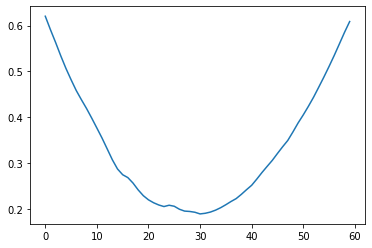

In [50]:
plt.plot(predictions.mean(0)[:,0])

# Inference

In [54]:
def inference_one(bs = 100, add_seed = 0, fold = 0, anum = 0):
    st = time.time()

    cur_epoch = getCurrentBatch(fold=fold)
    if cur_epoch is None: cur_epoch = 0
    print('completed epochs:', cur_epoch)

    model = TabularModel(n_cont = len(meta_cols), feat_sz=feat_sz)
    
    model_file_name = modelFileName(return_last=True, fold=fold)
    if model_file_name is not None:
        print('loading model', model_file_name)
        state_dict = torch.load(PATH_WORK/'models'/model_file_name)
        model.load_state_dict(state_dict)
    
    if (not CLOUD) or CLOUD_SINGLE:
        model = model.to(device)
    else:
        model_parallel = dp.DataParallel(model, device_ids=devices)

    setSeeds(SEED + cur_epoch + add_seed)

    tst_ds = RSNA_DataSet(test_md, mode='test', bs=bs, fold=fold)
    loader_tst = D.DataLoader(tst_ds, num_workers=8 if CLOUD else 0, batch_size=bs, shuffle=False)
    print('dataset test:', len(tst_ds), 'loader test:', len(loader_tst))
    
    tst_ds.setFeats(anum)

    loc_data = tst_ds.metadata.copy()
    series_counts = loc_data.index.value_counts()

    loc_data['orig_idx'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['SeriesInstanceUID','pos_idx1'])
    loc_data['my_order'] = np.arange(len(loc_data))
    loc_data = loc_data.sort_values(['orig_idx'])
    
    if CLOUD and (not CLOUD_SINGLE):
        results = model_parallel(test_loop_fn, loader_tst)
        predictions = np.concatenate([results[i][0] for i in range(MAX_DEVICES)])
        indices = np.concatenate([results[i][1] for i in range(MAX_DEVICES)])
        offsets = np.concatenate([results[i][2] for i in range(MAX_DEVICES)])
    else:
        predictions, indices, offsets = test_loop_fn(model, loader_tst, device)

    predictions = predictions[np.argsort(indices)]
    offsets = offsets[np.argsort(indices)]
    assert len(predictions) == len(test_md.SeriesInstanceUID.unique())
    assert np.all(indices[np.argsort(indices)] == np.array(range(len(predictions))))
    
    val_results = []
    for k, series in enumerate(np.sort(loc_data.index.unique())):
        cnt = series_counts[series]
        assert (offsets[k] + cnt) <= 60
        val_results.append(predictions[k,offsets[k]:(offsets[k] + cnt)])

    val_results = np.concatenate(val_results)
    assert np.isnan(val_results).sum() == 0
    val_results = val_results[loc_data.my_order]
    assert len(val_results) == len(loc_data)

    print('test processing time:', time.time() - st)
    
    return val_results

In [32]:
VERSION = 36

In [55]:
preds = []
for fold in range(3):
    preds2 = []
    for anum in range(32):
        predictions = inference_one(fold = fold, anum = -1)
        preds2.append(predictions)
    preds.append(np.stack(preds2))
preds = np.stack(preds)

completed epochs: 31
loading model model.b31.f0.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 10.128073453903198
completed epochs: 31
loading model model.b31.f0.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.853952169418335
completed epochs: 31
loading model model.b31.f0.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.376620531082153
completed epochs: 31
loading model model.b31.f0.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.19688606262207
completed epochs: 31
loading model model.b31.f0.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 0
dataset test: 2400 loader test: 24
setFeats, a

adding dummy serieses 186
DataSet 2 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.514747858047485
completed epochs: 32
loading model model.b32.f1.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.499049425125122
completed epochs: 32
loading model model.b32.f1.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.495244026184082
completed epochs: 32
loading model model.b32.f1.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.595972061157227
completed epochs: 32
loading model model.b32.f1.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 1
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.4817669391632

test processing time: 6.573482990264893
completed epochs: 28
loading model model.b28.f2.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 2
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.594020128250122
completed epochs: 28
loading model model.b28.f2.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 2
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.618808269500732
completed epochs: 28
loading model model.b28.f2.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 2
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.5019049644470215
completed epochs: 28
loading model model.b28.f2.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 2
dataset test: 2400 loader test: 24
setFeats, augmentation -1
test processing time: 6.503825426101685
completed epochs: 28
loading model model.b28.f2.v51
adding dummy serieses 186
DataSet 2 test size 2400 fold 2
datas

In [89]:
predictions = np.exp(np.log(preds).mean((0,1)))

In [43]:
predictions = 1 / (1 + np.exp(-(np.log(preds/(1-preds)).mean((0,1)))))

In [56]:
predictions = preds.mean((0,1))

In [57]:
predictions.mean(0)

array([0.1280228 , 0.00678272, 0.04317398, 0.03195811, 0.04593468,
       0.05528003], dtype=float32)

In [65]:
predictions.mean(0)

array([0.1264937 , 0.00635758, 0.04458478, 0.03210059, 0.0448006 ,
       0.05447438], dtype=float32)

In [90]:
predictions.mean(0)

array([0.12421313, 0.00613318, 0.04336379, 0.03132349, 0.04353321,
       0.05299766], dtype=float32)

In [58]:
id_column = np.array([a + '_' + b for a in test_md.SOPInstanceUID for b in all_ich])
sub = pd.DataFrame({'ID': id_column, 'Label': predictions.reshape(-1)})

In [59]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.12802280485630035

In [92]:
sub.loc[range(0,len(sub),6), 'Label'].mean()

0.12421312928199768

In [60]:
best_sub = pd.read_csv(PATH/'submission_061.csv')

In [61]:
best_sub.loc[range(0,len(sub),6), 'Label'].mean()

0.13475628267250275

In [62]:
sub.to_csv(PATH/'sub.csv', index=False)

In [63]:
np.corrcoef(sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'], 
            best_sub.sort_values('ID').reset_index(drop=True).loc[range(0,len(sub),6), 'Label'])[0,1]

0.9913718818923479

In [64]:
!kaggle competitions submit rsna-intracranial-hemorrhage-detection -f ~/sub.csv -m "TPU, new meta, densenet169, 4aug, 32TTA, 3folds, mean"

100%|██████████████████████████████████████| 16.6M/16.6M [00:05<00:00, 3.46MB/s]
Successfully submitted to RSNA Intracranial Hemorrhage Detection